# Siamese Network

This notebook explores creating a Siamese Network with a triplet-loss function to attempt to differentiate the images.

To do:

1. Build a Dataset that returns a single triplet of images.
2. Build a Dataloader for it too.
3. Construct a loss function.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict

from tqdm import tqdm_notebook as tqdm

from PIL import Image
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch import optim 
import torch


from matplotlib import pyplot as plt

In [3]:
def ceildiv(a, b):
    return -(-a // b)

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None, maintitle=None):
    """Function for plotting a bunch of images from fastai."""
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
        if (ims.shape[-1] != 3): ims = ims.transpose((0,2,3,1))
    if type(ims[0]) is torch.FloatTensor:
        ims = [i.permute(1,2,0) for i in ims]

    f = plt.figure(figsize=figsize)
    if maintitle is not None:
        plt.suptitle(maintitle, fontsize=16)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, ceildiv(len(ims), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [48]:
PATH = 'data/'

In [4]:
df = pd.read_csv(f'{PATH}train.csv')

In [4]:
from torchvision.datasets.folder import ImageFolder

In [5]:
class TripletFolder(ImageFolder):
    
    """
    Modification of ImageFolder.
    
    Return a triplet of images each iteration:

      1. anchor (the image at id).
      2. positive (an image from the same class as the anchor).
      3. negative (an image from a different class as the anchor).
    """

    def __init__(self, *args, **kwargs):
        super(TripletFolder, self).__init__(*args, **kwargs)
        
        self.class_to_imgs = defaultdict(list)
        for (path, class_id) in self.imgs:
            self.class_to_imgs[class_id].append(path)
            
        class_sizes = np.array([len(self.class_to_imgs[self.class_to_idx[c]]) for c in self.classes])
        self.class_weights = class_sizes / np.sum(class_sizes)

    def __getitem__(self, idx):
        anchor_path, target = self.imgs[idx]
        anchor_img = self.loader(anchor_path)
        
        other_imgs = self.class_to_imgs[target]
        positive_path = np.random.choice(other_imgs, 1)[0]
        positive_img = self.loader(positive_path)
    
        # Get a negative example, ensuring it's not from the class.
        negative_img = None
        while negative_img is None:
            other_class = np.random.choice(self.classes, 1, p=self.class_weights)[0]
            other_target = self.class_to_idx[other_class]
        
            if other_target == target:
                continue

            imgs = self.class_to_imgs[other_target]
            negative_path = np.random.choice(imgs, 1)[0]
            negative_img = self.loader(negative_path)
                
        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
    
        # Return a tuple of anchor, positive, negative
        return (anchor_img, positive_img, negative_img), []

In [6]:
from torchvision import transforms

transform = [
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.01, 0.01, 0.01),
    transforms.RandomGrayscale(p=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]

In [7]:
dataset_test = TripletFolder('./data/prepared/224/train/', transform=transforms.Compose(transform))

CPU times: user 264 ms, sys: 20 ms, total: 284 ms
Wall time: 130 ms


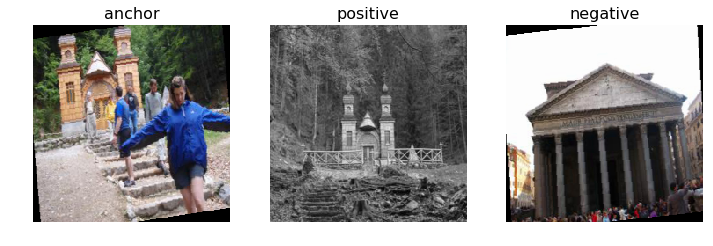

In [8]:
%time plots(dataset_test[0][0], titles=['anchor', 'positive', 'negative'])

CPU times: user 380 ms, sys: 56 ms, total: 436 ms
Wall time: 56.3 ms


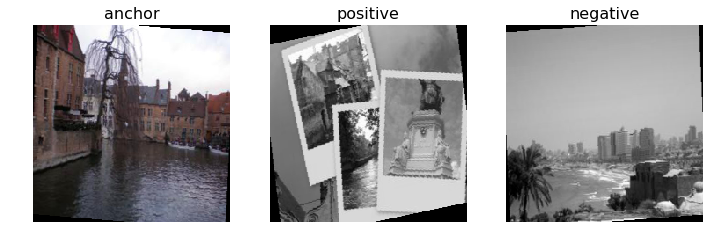

In [9]:
%time plots(dataset_test[500][0], titles=['anchor', 'positive', 'negative'])

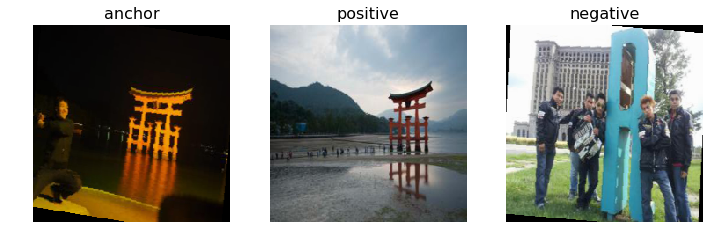

In [10]:
plots(dataset_test[1000][0], titles=['anchor', 'positive', 'negative'])

In [11]:
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = [
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.01, 0.01, 0.01),
    transforms.RandomGrayscale(p=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
]

In [12]:
from torch.utils.data import DataLoader

from torchvision import models
from torch import nn

In [13]:
latent_dim = 128

Want to load ResNet50, then replace the final layers with a fully-connected layer with some number of latent factors.

In [14]:
class SiameseNet(nn.Module):
    
    def __init__(self):
        super(SiameseNet, self).__init__()
        
        self.base_model = models.resnet34(pretrained=True)
        
        for param in self.base_model.parameters():
            param.requires_grad = False
    
        self.base_model.fc = nn.Linear(
            self.base_model.fc.in_features, latent_dim)
        
    def forward(self, anchor, primary, negative):
        anchor_out = self.base_model(anchor)
        primary_out = self.base_model(primary)
        negative_out = self.base_model(negative)
        
        return (anchor_out, primary_out, negative_out)

In [15]:
model = SiameseNet()
bs = 32

In [17]:
model = model.cuda()

dataset = TripletFolder(
    './data/prepared/340/train/', transform=transforms.Compose(transform))
dl = DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=8)

lr = 0.01
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
running_loss = 0.0

t = tqdm(enumerate(dl), total=len(dl))
for batch_idx, (data, target) in t: 
    anchors_in, positives_in, negatives_in = data
    
    anchors_out, positives_out, negatives_out = model(
        Variable(anchors_in.cuda()),
        Variable(positives_in.cuda()),
        Variable(negatives_in.cuda()))
    
    optimizer.zero_grad()
    
    loss = nn.functional.triplet_margin_loss(anchors_out, positives_out, negatives_out)

    loss.backward()
    
    optimizer.step()
    
    # print stats
    running_loss += loss.data[0]
    if (batch_idx + 1) % 10 == 0:
        avg_loss = running_loss / (batch_idx + 1)
        t.set_description(f'[{avg_loss}]')

Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f82240e3c88>>
Traceback (most recent call last):
  File "/home/lex/anaconda3/envs/landmark-recognition-challenge/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 333, in __del__
    self._shutdown_workers()
  File "/home/lex/anaconda3/envs/landmark-recognition-challenge/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 319, in _shutdown_workers
    self.data_queue.get()
  File "/home/lex/anaconda3/envs/landmark-recognition-challenge/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/lex/anaconda3/envs/landmark-recognition-challenge/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/home/lex/anaconda3/envs/landmark-recognition-challenge/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detac